In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob

import healpy

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from astropy.table import Table, vstack
from astropy.io import fits

from shapely.geometry import Polygon as poly_shapely
from shapely.ops import cascaded_union

In [2]:
from damascus import io
from damascus import hsc
from damascus import utils
from damascus import sweep

In [3]:
def get_overlapped_sweep(sweep_list, hsc_fdfc_pkl):
    '''Get the list of overlapped Sweep catalogs.
    '''
    # Decode the Sweep lists into coordinates of the box regions
    sweep_boxes = [sweep.sweep_to_box(name) for name in sweep_list]

    # Read HSC FDFC region files
    hsc_fdfc_regions = io.read_from_pickle(hsc_fdfc_pkl)

    # Combine the HSC fields together
    hsc_fdfc_union = cascaded_union(
        [poly_shapely(hsc_fdfc_regions[idx + 1])
         for idx in np.arange(len(hsc_fdfc_regions))])

    # Get the list of overlapped sweep catalogs
    sweep_overlap = list(
        np.asarray(sweep_list)[
            [hsc_fdfc_union.intersects(poly_shapely(box)) 
             for box in sweep_boxes]])
    
    return sweep_overlap

### DR8 Sweep catalog list

In [6]:
with open('../../damascus/data/decals/dr8/decals_dr8_sweeps.list', 'r') as ll:
    dr8_sweep_list = ll.read().splitlines()
    
_ = io.save_to_pickle(dr8_sweep_list, '../../damascus/data/decals/dr8/decals_dr8_sweeps.pkl')

In [7]:
s19a_fdfc_pkl = '../../damascus/data/hsc/s19a_fdfc_borders_poly.pkl'
s18a_fdfc_pkl = '../../damascus/data/hsc/s18a_fdfc_borders_poly.pkl'

sweep_s19a_overlap = get_overlapped_sweep(dr8_sweep_list, s19a_fdfc_pkl)
sweep_s18a_overlap = get_overlapped_sweep(dr8_sweep_list, s18a_fdfc_pkl)

print(len(sweep_s18a_overlap), len(sweep_s19a_overlap))

_ = io.save_to_pickle(sweep_s19a_overlap, '../../damascus/data/decals/dr8/decals_dr8_sweep_s19a_overlap.pkl')
_ = io.save_to_pickle(sweep_s18a_overlap, '../../damascus/data/decals/dr8/decals_dr8_sweep_s18a_overlap.pkl')

31 35


(-15.0, 50.0)

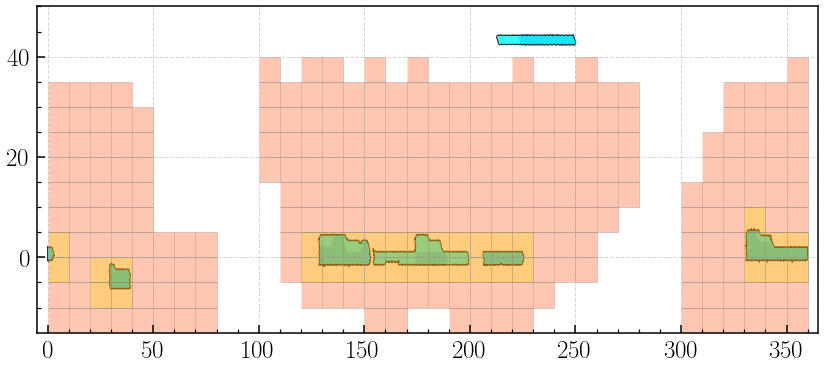

In [9]:
s19a_poly = io.read_from_pickle('../../damascus/data/hsc/s19a_fdfc_poly.pkl')
s18a_poly = io.read_from_pickle('../../damascus/data/hsc/s18a_fdfc_poly.pkl')

s18a_polygons = [Polygon(s18a_poly[idx + 1], closed=False) for idx in np.arange(len(s18a_poly))]
s19a_polygons = [Polygon(s19a_poly[idx + 1], closed=False) for idx in np.arange(len(s19a_poly))]

sweep_boxes = [sweep.sweep_to_box(name) for name in dr8_sweep_list]
sweep_polygons = [Polygon(box, closed=False) for box in sweep_boxes]

overlap_boxes = [sweep.sweep_to_box(name) for name in sweep_s19a_overlap]
overlap_polygons = [Polygon(box, closed=False) for box in overlap_boxes]

# 
fig, ax = plt.subplots(figsize=(14, 6))

ax.add_collection(PatchCollection(s18a_polygons, facecolor='royalblue', edgecolor='none', alpha=0.8))
ax.add_collection(PatchCollection(s19a_polygons, facecolor='cyan', edgecolor='k', alpha=0.8))

ax.add_collection(PatchCollection(sweep_polygons, edgecolor='gray', facecolor='orangered', alpha=0.3))
ax.add_collection(PatchCollection(overlap_polygons, edgecolor='gray', facecolor='gold', alpha=0.3))

ax.set_xlim(-5, 365)
ax.set_ylim(-15, 50)